# Classical and bayesian linear models, test of the functions.

The preprocessing step uses the conclusions of the Exploratory script , and reproduces a part of it.

A (relatively simple) classical linear model, then a bayesian linear model is trained on the 5 numerical features with the highest correlation with the target variable.

The performance of the models is checked using the stratified train-test split. All variables are normalized then both models are trained, and their Mean Absolute Errors on test set are stored. 

The price prediction of the bayesian linear model is performed by computing a sample from the posterior predictive distribution of the normalized log-price, then converting it to a distribution of prices, then taking the mean. Although the intermediate results show that the estimates of coefficients are similar for both models, the conversion to the prices (mean of exponents of the predictive distribution for the Bayesian model versus exponent of the mean for the linear model) creates a difference between predictions. This script can serve as a test for the module 'bayesian_linear.py' for bayesian models.

------------------------
Result.

The point estimates of coefficients of the bayesian model are close to those of the classical one. But the nonlinear conversion to the scale of real prices allows indeed different performances.

This specific train-test split shows an unexpected property: the prediction is better on test, than on train. The bayesian model shows better performance (smaller MAE) on the train set, but worse performance on the test set, therefore its scores are closer to each other. As the mean of 70 splits (the main script 'stratified_kfold') shows, this behavior is not systematic and should be attributed to the nature of this specific split.

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns # for plotting the posterior distributions of coefficients.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

import arviz as az

from scale_target import ScaleTarget
import bayesian_linear as blm


In [2]:
# load data
file_path  = '../dat/train.csv'
data = pd.read_csv(file_path, index_col=0,  na_values='NA', keep_default_na=False)
del file_path

data.shape

(1460, 80)

# Preprocess variables.

1. Reset index  to ensure that the indices returned by 'StratifiedKFold' (from 0 to 1459) are correctly interpreted.

In [3]:
data.reset_index(inplace=True, drop=True)

2. Remove categorical features, those with many missing values or with high correlation with other ones.

In [4]:
# remove features with many missing values
features_with_na=data.isna().sum()[data.isna().sum()>0] / data.shape[0]  # ( this long line should be replaced by a 'def' )
list_to_drop=features_with_na[features_with_na > 0.1].index.tolist()
# drop the features with more than 10% of NA

list_to_drop
# ['LotFrontage', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] 

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [5]:
data.drop(list_to_drop, axis=1, inplace=True)
# remove these columns

print(data.shape)  # (1460, 74)

(1460, 74)


In [6]:
# feature selection
data = data.select_dtypes(include='number')

print(data.shape)
# (1324, 36)

(1460, 36)


In [7]:
# The features GarageCars , TotalBsmtSF should be removed because of high correlation with other ones.
# This is detected by the Exploratory Data Analysis.
data.drop(columns=['GarageCars', 'TotalBsmtSF'], inplace=True)

3. log(target variable)

In [8]:
data['LogSalePrice'] = np.log1p(data.SalePrice)  # inverse function: predicted_price = exp(y_pred) - 1 .
target = 'LogSalePrice'

# separate the original target variable to keep it available for interpreting the model predictions,
# but to avoid it being detected as column with high correlation with the new target.
data_Sale_price = data['SalePrice']  # for comparing the model predictions with the real prices
data.drop(columns='SalePrice', inplace=True)

print(data_Sale_price.shape)  # (1460,)
print(data_Sale_price.mean()) # 180921 $


(1460,)
180921.19589041095


In [9]:
# Keep the target and 5 most correlated numerical features for the model. 
k = 6

corrmat = data.corr()
cols = corrmat.nlargest(k, target).index.tolist()
# The names of features with highest correlation with log(SalePrice) .

"""
[
'LogSalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'FullBath',]
"""

cols
# As expected, the target variable 'LogSalePrice' is at the 1st position.

['LogSalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageArea',
 '1stFlrSF',
 'FullBath']

In [10]:
# keep the 6 selected columns.
data = data[cols]
print(data.shape)  # (1460, 6)
data.head()

(1460, 6)


,LogSalePrice,OverallQual,GrLivArea,GarageArea,1stFlrSF,FullBath
0,12.247699,7,1710,548,856,2
1,12.109016,6,1262,460,1262,2
2,12.317171,7,1786,608,920,2
3,11.849405,7,1717,642,961,1
4,12.429220,8,2198,836,1145,2


In [11]:
data.isnull().sum()
# Zeroes! The remaining columns have no missing values. 

LogSalePrice    0
OverallQual     0
GrLivArea       0
GarageArea      0
1stFlrSF        0
FullBath        0
dtype: int64

# Discretisation of prices.

In [12]:
price_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal')
#  default strategy : 'quantile'

y_discretized = price_discretizer.fit_transform(data[[target]])

print(type(price_discretizer))  # 'sklearn.preprocessing._discretization.KBinsDiscretizer'
print(price_discretizer.bin_edges_)
# [array([10.46027076, 11.57567464, 11.72804491, 11.8167343 , 11.89819467,
#         12.00151161, 12.09670954, 12.19915334, 12.34583894, 12.53537999,
#         13.53447435]) 

print(y_discretized.shape)  # (1460, 1) 

# append y_discretized to the Dataframe.
data['discr_price'] = y_discretized

# Take a look at the data with the discretizer
print(data.shape)  # (1460, 7)
data.head()

<class 'sklearn.preprocessing._discretization.KBinsDiscretizer'>
[array([10.46027076, 11.57567464, 11.72804491, 11.8167343 , 11.89819467,
        12.00151161, 12.09670954, 12.19915334, 12.34583894, 12.53537999,
        13.53447435])                                                   ]
(1460, 1)
(1460, 7)


,LogSalePrice,OverallQual,GrLivArea,GarageArea,1stFlrSF,FullBath,discr_price
0,12.247699,7,1710,548,856,2,7.0
1,12.109016,6,1262,460,1262,2,6.0
2,12.317171,7,1786,608,920,2,7.0
3,11.849405,7,1717,642,961,1,3.0
4,12.429220,8,2198,836,1145,2,8.0


<Axes: >

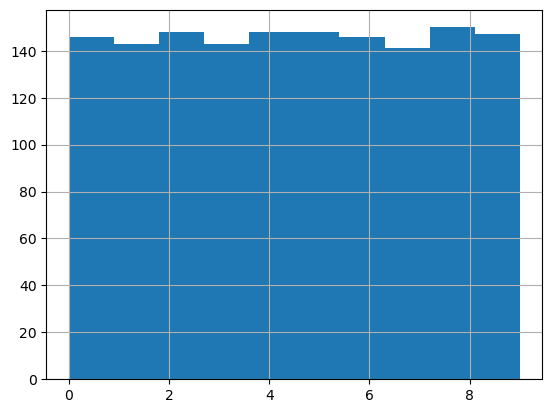

In [13]:
data['discr_price'].hist()
# The histogram is uniform, which is normal for the quantile strategy.
# Each bin contains more than 140 samples, which is enough for a stratified split.

# Train-test split.

In [14]:
# Submission 1 :
#data_train, data_test = train_test_split(data[cols], test_size=0.2, stratify=data['discr_price'], random_state=42)
# This removes the column 'discr_price' from the train and test sets.

# data_train, data_test, sale_price_train, sale_price_test = train_test_split(data[cols], data_Sale_price,
#                                                                             test_size=0.2, stratify=data['discr_price'], random_state=42)
X_train, X_test, Y_train, __, sale_price_train, sale_price_test = train_test_split(data[cols[1:]], data[target],  data_Sale_price,
                                                                            test_size=0.2, stratify=data['discr_price'], random_state=42)

print(X_train.shape)  # (1168, 6) -> (1168, 5)
print(sale_price_train.shape)  # (1168, )
print(sale_price_train.mean())  # 181018 $
print(sale_price_test.mean())   # 180532 $

# data_train.head()
X_train.head()

(1168, 5)
(1168,)
181018.54452054793
180531.801369863


,OverallQual,GrLivArea,GarageArea,1stFlrSF,FullBath
655,6,1092,264,525,1
265,6,1422,576,1422,2
283,8,1468,898,1468,2
1354,7,1865,839,992,2
138,8,1852,660,1004,2


# Normalization.

In [15]:
# scale the features
X_scal = StandardScaler()
norm_train_features = X_scal.fit_transform(X_train)
norm_test_features = X_scal.transform(X_test)

# scale the target.
norm_Y_train, Sale_Price = ScaleTarget(Y_train)

def posterior_predictive_mae(sale_price, df_posterior_pred):
    """
    Predicts prices in initial scale using each column as a sample
    from posterior predictive distribution of normed log-price.
    The prediction rule is: convert the distribution to a distribution of real prices
    (denormalization, followed by exponent),
    then take its mean.

    Args:
        sale_price (Series): the ground truth about prices of transactions.    
        df_posterior_pred (DataFrame with one column per row of the initial distribution):
            the posterior predictive distributions of normed log-price ;

    Returns:
        float: the MAE of Bayesian prediction.
    """
    
    pred_price_bayes = Sale_Price(df_posterior_pred).mean()
    return mean_absolute_error(sale_price, pred_price_bayes)

# Define the model of multiple linear regression.

In [16]:
reg = LinearRegression().fit(norm_train_features, norm_Y_train)

print("Coefficients of the model:", reg.coef_)
# [0.4943 0.1925 0.1805 0.1270 0.0793]

print("Intercept:", reg.intercept_)
# -2.13e-15
print("----------")

# Performance on train, test sets (in terms of price).
pred_norm_log_train = reg.predict(norm_train_features)
pred_price_train = Sale_Price(pred_norm_log_train) 
mae_lin_reg_train =  np.round(mean_absolute_error(sale_price_train, pred_price_train)) # 24043 $
print("The MAE of price prediction on train set is: ", mae_lin_reg_train, "$")

pred_norm_log_test = reg.predict(norm_test_features)
pred_price_test = Sale_Price(pred_norm_log_test)
mae_lin_reg_test =  np.round(mean_absolute_error(sale_price_test, pred_price_test)) # 21337 $
print("The MAE of price prediction on test set is: ", mae_lin_reg_test, "$")

Coefficients of the model: [0.49434443 0.19245758 0.18057817 0.12700744 0.07932889]
Intercept: -2.1309369501714755e-15
----------
The MAE of price prediction on train set is:  24043.0 $
The MAE of price prediction on test set is:  21337.0 $


The mean average error of the linear model on the test set is of order 20000 $.

# Define the model of bayesian linear regression using the function bayesian_linear fit.

In [17]:
# Inferring regression coefficients
idata = blm.fit(norm_train_features, observed=norm_Y_train.to_frame())

# 6 sec

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

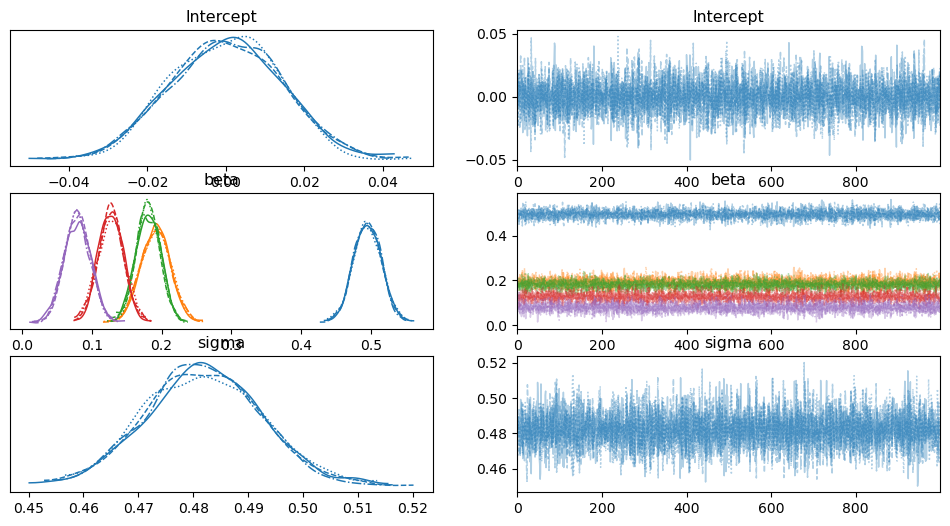

In [18]:
# Plot trace. 

az.plot_trace(idata)

In [19]:
# check the coefficients.
az.summary(idata).head(n=len(cols)+1)

# Rows: Intercept, beta[(feat_index: int):0,0] , beta[1,0] , beta[2,0], beta[3,0] , beta[4,0], sigma
# Intercept : mean=0.0 , sd=0.014
# beta[0,0] : mean=0.494, sd=0.02  {blue distribution}
# beta[1,0] : mean=0.192, sd=0.022 {yellow distribution}
# beta[2,0] : mean=0.181, sd=0.018 {green distribution}
# beta[3,0] : mean=0.127, sd=0.018 {red distribution}
# beta[4,0] : mean=0.079, sd=0.019 {violet distribution}
# sigma : mean=0.482, sd=0.01 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.000,0.014,-0.027,0.024,0.0,0.0,6633.0,2938.0,1.0
"beta[0, 0]",0.495,0.020,0.459,0.535,0.0,0.0,5947.0,3177.0,1.0
"beta[1, 0]",0.191,0.021,0.152,0.231,0.0,0.0,5099.0,3453.0,1.0
"beta[2, 0]",0.181,0.017,0.147,0.212,0.0,0.0,6035.0,3144.0,1.0
"beta[3, 0]",0.127,0.018,0.094,0.163,0.0,0.0,5425.0,3080.0,1.0
"beta[4, 0]",0.079,0.019,0.046,0.116,0.0,0.0,5779.0,3356.0,1.0
sigma,0.482,0.010,0.463,0.502,0.0,0.0,6704.0,2967.0,1.0


The mean values of the coefficients Intercept, beta[0] to beta[4] are close (up to 3 digits) to those of the linear regression.

# Extract and plot distributions of coefficients.

In [20]:
df_idata_full = idata.to_dataframe()
print(df_idata_full.shape)  # (4000, 26)

(4000, 26)


[<Axes: xlabel="('posterior', 'beta[0,0]', 0, 0)", ylabel='Count'>,
 <Axes: xlabel="('posterior', 'beta[1,0]', 1, 0)", ylabel='Count'>,
 <Axes: xlabel="('posterior', 'beta[2,0]', 2, 0)", ylabel='Count'>,
 <Axes: xlabel="('posterior', 'beta[3,0]', 3, 0)", ylabel='Count'>,
 <Axes: xlabel="('posterior', 'beta[4,0]', 4, 0)", ylabel='Count'>]

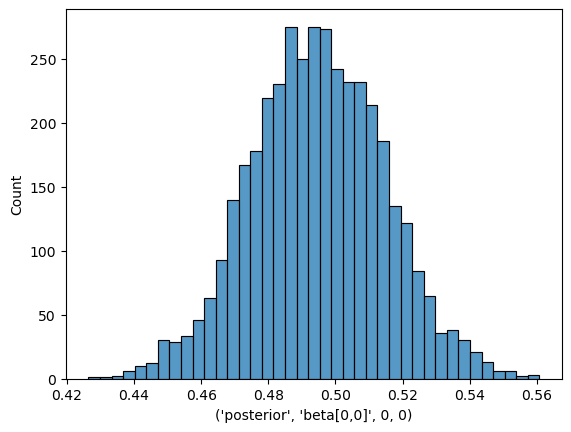

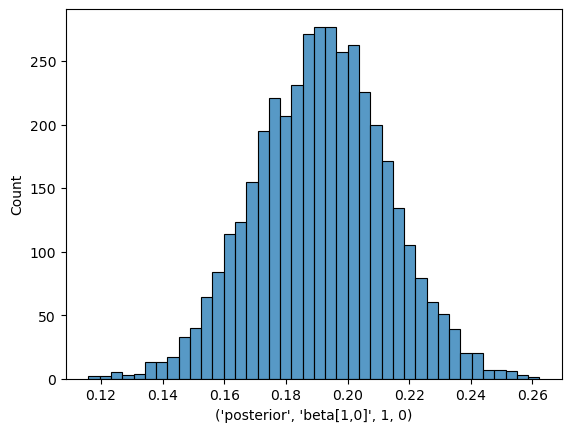

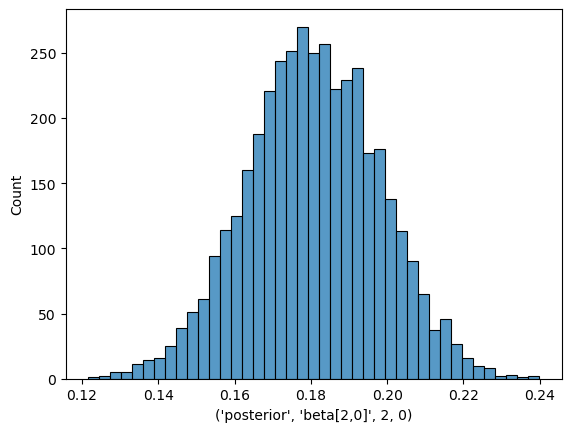

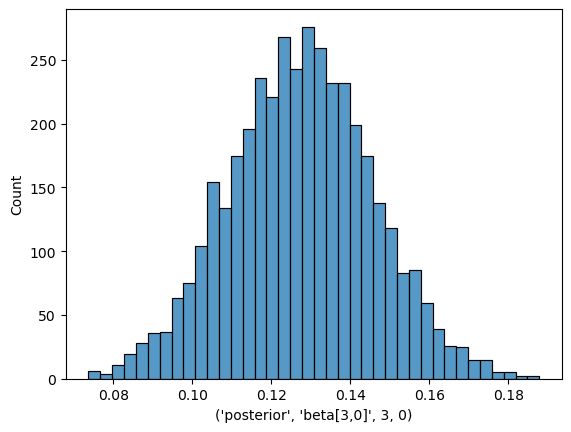

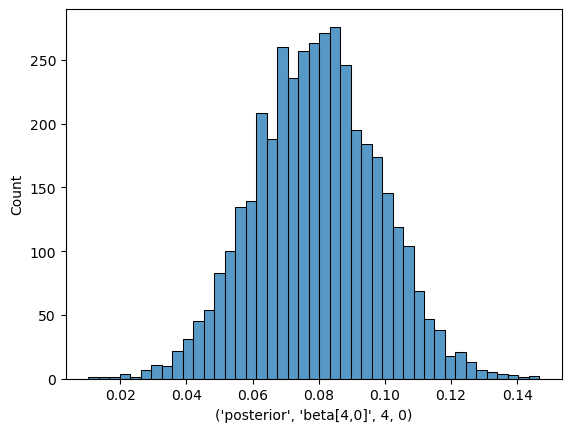

In [21]:
def plot_posterior_beta(feat_index: int):
    _, ax = plt.subplots()
    
    sns.histplot(df_idata_full[blm.ind_to_col_name(feat_index)])
    return ax


list(map(plot_posterior_beta, range(norm_train_features.shape[1])))

The distributions of all coefficients look quite similar to normal.

Prediction on the test set.

In [22]:
# Computing the posterior predictive distributions of normalized prices. 
pp = blm.predict(idata, norm_train_features, norm_test_features)
# 0.3s

Sampling: [y]


MAE of prediction of prices by the bayesian regression.

In [23]:
df_pp_full = pp.to_dataframe()
train_size = norm_train_features.shape[0]

lst_cols_train = list(map(blm.ind_to_col_name_pp, range(train_size)))
df_posterior_pred_train = df_pp_full[lst_cols_train]

In [24]:
pred_price_train_bayes = Sale_Price(df_posterior_pred_train).mean()
mae_lin_reg_train_bayes =  mean_absolute_error(sale_price_train, pred_price_train_bayes)
print("The MAE of price prediction on train set by Bayesian model is: ", np.round(mae_lin_reg_train_bayes), "$")
# 23874 $

# Recall. Linear regression gives:
# 24043 $

The MAE of price prediction on train set by Bayesian model is:  23875.0 $


In [25]:
# Test set

test_size = norm_test_features.shape[0]
lst_cols_test = list(map(blm.ind_to_col_name_pp, range(train_size, train_size + test_size)))
df_posterior_pred_test = df_pp_full[lst_cols_test]

In [26]:
pred_price_test_bayes = Sale_Price(df_posterior_pred_test).mean()
mae_lin_reg_test_bayes =  mean_absolute_error(sale_price_test, pred_price_test_bayes)
print("The MAE of price prediction on test set by Bayesian model is: ", np.round(mae_lin_reg_test_bayes), "$")
# 21428 $

# Recall. Linear regression gives:
# 21337 $

The MAE of price prediction on test set by Bayesian model is:  21431.0 $


# Bayesian prediction using the function 'fit_predict'.

This shorter block of instructions produces the same final results as the previous bayesian model. 

In [27]:
def posterior_predictive_mae(df_posterior_pred, sale_price):
    pred_price_bayes = Sale_Price(df_posterior_pred).mean()
    return mean_absolute_error(sale_price, pred_price_bayes)

In [28]:
df_posterior_pred_train, df_posterior_pred_test = blm.fit_predict(
            norm_train_features, norm_test_features, observed=norm_Y_train.to_frame())

# norm_Y_train
# 6 sec

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


In [29]:
# Compute MAE of the bayesian model.
print("The MAE of price prediction on train set (using the function) is: ", 
      np.round(posterior_predictive_mae(df_posterior_pred_train, sale_price_train)), "$")
# 23874 $

The MAE of price prediction on train set (using the function) is:  23875.0 $


In [30]:
print("The MAE of price prediction on test set (using the function) is: ", 
      np.round(posterior_predictive_mae(df_posterior_pred_test, sale_price_test)), "$")
# 21428 $

The MAE of price prediction on test set (using the function) is:  21431.0 $


The MAE of predicting the prices by the Bayesian model is lower on the train set, but higher on the test set. One thing is positive: the exponents before means lead to different predictions between two models.

| Subset of data | MAE of Lin-reg | MAE of Bayesian |
| :------------- | :------------- | :-------------- |
| Train          | 24043          | 23874           |
| Test           | 21337          | 21428           |